In [12]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
import random
import seaborn as sns
from PIL import ImageFilter, ImageOps, Image
import torch.optim as optim
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def get_resnet_backbone():
    model = resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = torch.nn.Identity()
    return model, in_features

In [14]:
class GaussianBlur(object):
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )
        
class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

In [15]:
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            GaussianBlur(0.1),
            Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [16]:
transform = DataAugmentationDINO(
        (0.4, 1.), # global crops scale
        (0.05, 0.4), # local crops number
        8 # local crops scale
    )

In [17]:
unlabeled_dataset = STL10(root='../data/dino', split='unlabeled', download=True, transform=transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [18]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=64, use_bn=False):
        super(DINOHead, self).__init__()
        layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim)
        ]
        if use_bn:
            layers.insert(1, nn.BatchNorm1d(hidden_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class DINOLoss(nn.Module):
    def __init__(self, out_dim, teacher_temp=0.04, student_temp=0.1, center_momentum=0.996):
        super(DINOLoss, self).__init__()
        self.register_buffer("center", torch.zeros(1, out_dim))
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.center_momentum = center_momentum

    def forward(self, student_output, teacher_output):
        teacher_output = F.softmax((teacher_output - self.center) / self.teacher_temp, dim=-1).detach()
        student_output = F.log_softmax(student_output / self.student_temp, dim=-1)
        loss = torch.mean(torch.sum(-teacher_output * student_output, dim=-1))
        self.update_center(teacher_output)
        return loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = torch.mean(teacher_output, dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

class DINO(nn.Module):
    def __init__(self, backbone, head):
        super(DINO, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

backbone, in_features = get_resnet_backbone()
student_head = DINOHead(in_dim=in_features, out_dim=1024)
teacher_head = DINOHead(in_dim=in_features, out_dim=1024)

student = DINO(backbone, student_head)
teacher = DINO(backbone, teacher_head)

for param in teacher.parameters():
    param.requires_grad = False

criterion = DINOLoss(out_dim=1024)

In [31]:
def save_best_model(student, path):
    torch.save(student.state_dict(), path)
    
def save_losses(losses, path):
    with open(path, 'w') as f:
        for loss in losses:
            f.write(f'{loss}\n')
            
def load_model(student, path):
    student.load_state_dict(torch.load(path))
    return student

In [20]:
def plot_loss_curve(losses):
    sns.axes_style("whitegrid")
    sns.color_palette("viridis", as_cmap=True)
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('DINO Loss Curve')
    plt.legend(['Loss'])
    plt.show()

In [21]:
import torch.utils.data as data_utils
indices = torch.arange(10000)
unlabeled_subset = data_utils.Subset(unlabeled_dataset, indices)
unlabeled_loader_subset = DataLoader(unlabeled_subset, batch_size=64, shuffle=True)

In [35]:
def momentum_update(student, teacher, m=0.996):
    for param_q, param_k in zip(student.parameters(), teacher.parameters()):
        param_k.data = param_k.data * m + param_q.data * (1. - m)

def train_dino(student, teacher, criterion, optimizer, dataloader, patient, num_epochs=100):
    student = student.to(device)
    teacher = teacher.to(device)
    criterion = criterion.to(device)
    losses = []
    patient_count = 0
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = [img.to(device) for img in images] 

            # Forward pass
            student_outputs = [student(img) for img in images]
            with torch.no_grad():
                teacher_outputs = [teacher(img) for img in images]

            total_loss = 0
            n_crops = len(images)
            for i in range(n_crops):
                for j in range(n_crops):
                    if i != j:
                        loss = criterion(student_outputs[i], teacher_outputs[j])
                        total_loss += loss

            total_loss /= n_crops * (n_crops - 1)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            momentum_update(student, teacher)

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(dataloader)
        best_loss = min(best_loss, avg_loss)
        if avg_loss > best_loss:
            patient_count += 1
            if patient_count == patient:
                print(f'Early stopping at epoch {epoch+1}')
                return losses

        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        if avg_loss == best_loss:
            save_best_model(student, '../models/dino_checkpoints/best_dino_2.pth')
    return losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = student.to(device)
teacher = teacher.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(student.parameters(), lr=1e-3)
num_epochs = 50
patient = 5
losses = train_dino(student, teacher, criterion, optimizer, unlabeled_loader_subset, patient, num_epochs=num_epochs)

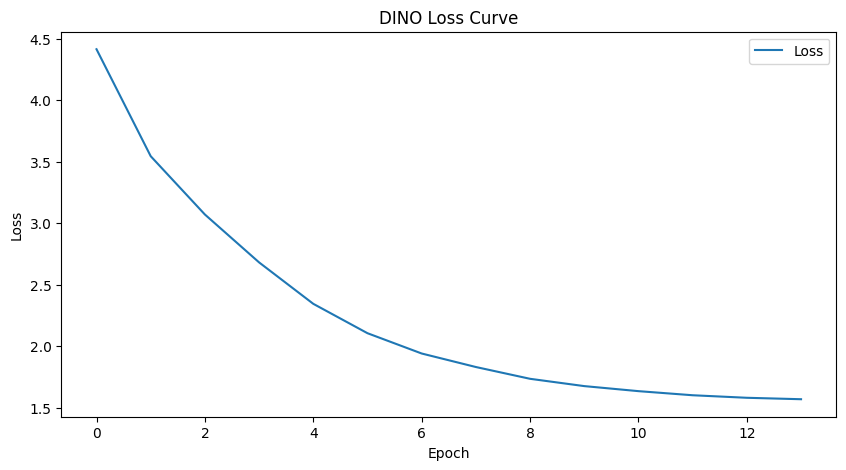

In [28]:
plot_loss_curve(losses)

In [34]:
trained_model = load_model(student, '../models/dino_checkpoints/best_dino.pth')
losses_loaded = train_dino(trained_model, teacher, criterion, optimizer, unlabeled_loader_subset, patient, num_epochs=num_epochs)

Epoch 1/50:   2%|▏         | 3/157 [00:06<05:52,  2.29s/it]


KeyboardInterrupt: 